Running on device: cpu


100%|██████████| 26421880/26421880 [00:20<00:00, 1308219.53it/s]


Extracting ./data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 29515/29515 [00:00<00:00, 118014.64it/s]


Extracting ./data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 4422102/4422102 [00:09<00:00, 487941.40it/s] 


Extracting ./data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 5148/5148 [00:00<00:00, 5189203.80it/s]


Extracting ./data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw

Epoch 1/5, Loss: 0.4299
Epoch 2/5, Loss: 0.2723
Epoch 3/5, Loss: 0.2268
Epoch 4/5, Loss: 0.1927
Epoch 5/5, Loss: 0.1674
Test Accuracy: 91.51%
Precision: 0.9158
Recall: 0.9151
Saved predictions to predicted_images.png


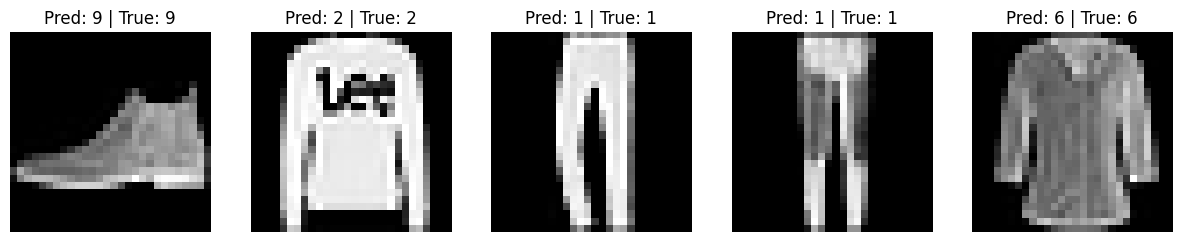

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score
import os

# Set the device to CUDA if GPU is available, else CPU
compute_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on device: {compute_device}")

# Data preprocessing: normalizing images for better training performance
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize pixel values
])

# Download the FashionMNIST dataset
train_set = datasets.FashionMNIST(root='./data', train=True, download=True, transform=data_transforms)
test_set = datasets.FashionMNIST(root='./data', train=False, download=True, transform=data_transforms)

# DataLoader setup for batching
train_batch = DataLoader(train_set, batch_size=64, shuffle=True)
test_batch = DataLoader(test_set, batch_size=64, shuffle=False)

# Define a custom Convolutional Neural Network class for image classification
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Layer 1: Convolutional layer (32 filters, kernel size 3)
        self.conv_layer1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        # Layer 2: Convolutional layer (64 filters, kernel size 3)
        self.conv_layer2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        # Fully connected layer with 128 units
        self.fc_layer1 = nn.Linear(64 * 7 * 7, 128)
        # Final output layer (10 classes)
        self.fc_layer2 = nn.Linear(128, 10)

    def forward(self, x):
        # Pass the input through the network layers
        x = torch.relu(self.conv_layer1(x))
        x = torch.max_pool2d(x, 2)  # Max pooling with stride 2
        x = torch.relu(self.conv_layer2(x))
        x = torch.max_pool2d(x, 2)  # Max pooling with stride 2
        x = x.view(x.size(0), -1)  # Flatten the tensor for fully connected layer
        x = torch.relu(self.fc_layer1(x))
        x = self.fc_layer2(x)
        return x

# Initialize the model
cnn_model = SimpleCNN().to(compute_device)

# Use multiple GPUs if available
if torch.cuda.device_count() > 1:
    cnn_model = nn.DataParallel(cnn_model)

# Define loss function and optimizer
loss_criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

# Training function
def train_cnn(model, data_loader, optimizer, loss_function, device, epochs=5):
    model.train()  # Set the model to training mode
    for epoch in range(epochs):
        epoch_loss = 0.0
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()  # Zero the gradients
            
            outputs = model(images)  # Get predictions
            loss = loss_function(outputs, labels)  # Calculate loss
            loss.backward()  # Backpropagate the loss
            optimizer.step()  # Update model weights
            
            epoch_loss += loss.item()  # Accumulate loss for the epoch

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss / len(data_loader):.4f}")

# Start training the model
train_cnn(cnn_model, train_batch, optimizer, loss_criterion, compute_device)

# Evaluation function
def evaluate_cnn(model, data_loader, device):
    model.eval()  # Set the model to evaluation mode
    total_correct = 0
    total_samples = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():  # No need to calculate gradients during evaluation
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            predictions = model(images)  # Get model predictions
            _, predicted_labels = torch.max(predictions, 1)
            
            total_samples += labels.size(0)
            total_correct += (predicted_labels == labels).sum().item()  # Count correct predictions
            
            all_preds.extend(predicted_labels.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100 * total_correct / total_samples
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')

    print(f"Test Accuracy: {accuracy:.2f}%")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")

    return accuracy, precision, recall

# Evaluate the trained model
evaluate_cnn(cnn_model, test_batch, compute_device)

# Visualization and saving predicted images
def plot_and_save_predictions(model, data_loader, device, num_images=5, save_path='predicted_images.png'):
    model.eval()
    images, labels = next(iter(data_loader))
    images, labels = images[:num_images].to(device), labels[:num_images].to(device)
    
    predictions = model(images)
    _, predicted_labels = torch.max(predictions, 1)
    
    # Plot the images along with predicted and true labels
    fig, ax = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        ax[i].imshow(images[i].cpu().squeeze(), cmap='gray')  # Squeeze to remove extra color channels
        ax[i].set_title(f"Pred: {predicted_labels[i].item()} | True: {labels[i].item()}")
        ax[i].axis('off')  # Remove axes for cleaner output

    # Save the visualization to a file
    plt.savefig(save_path)
    print(f"Saved predictions to {save_path}")
    
    plt.show()

# Call the function to visualize and save the predictions
plot_and_save_predictions(cnn_model, test_batch, compute_device, num_images=5, save_path='predicted_images.png')
